# Import dependencies and modules

In [26]:
import requests
from citipy import citipy
import time
from api_keys import api_keys
import pandas as pd
from os.path import exists
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.stats as st
pd.set_option('display.max_columns', None)

## Create methods to help executte the requests

In [27]:
def save_chart(name: str):
    if os.path.exists("images/"):
        plt.savefig(f'images/{name}')
    else:
        os.mkdir("images/")
        save_chart(name)
        
        
def wait():
    time.sleep(300)


def rand_long():
    return float(np.random.randint(-180, 180))


def rand_lat():
    return float(np.random.randint(-90, 90))


def get_weather(data_frame: pd.DataFrame, first: bool):
    keys = api_keys()
    non_cities = []
    city_names = []
    city_long = []
    city_lat = []
    city_temp = []
    city_humidity = []
    city_cloudiness = []
    city_wind = []
    output_file = open("Outputs/Text_Outputs/generating_cities.txt", "a+")
    output_file.write("Now writing to output file!\n")
    counter = 0  # Create an index counter
    if first:
        while counter < 50:
            rand_city = citipy.nearest_city(rand_long(), rand_lat()).city_name
            request = requests.get(f'https://api.openweathermap.org/data/2.5/weather?appid={keys.get_weather_key()}&q='
                                   f'{rand_city}&units=imperial').json()
            if request["cod"] == '404':
                print(f'{rand_city} does not exist')
                output_file.write(f'{rand_city} does not exist\n')
            elif request["cod"] == '429':
                print("Time out for requests...")
                output_file.write("Time out for requests...\n")
                wait()
            else:
                if request["name"] not in city_names:
                    try:
                        output_file.write(f'{counter} {request["name"].encode(sys.stdout.encoding, errors="replace")} '
                                          f'added\n')
                        city_names.append(request["name"])
                        city_long.append(request["coord"]["lon"])
                        city_lat.append(request["coord"]["lat"])
                        city_temp.append(request["main"]["temp"])
                        city_humidity.append(request["main"]["humidity"])
                        city_cloudiness.append(request["clouds"]["all"])
                        city_wind.append(request["wind"]["speed"])
                        print(f'{counter} {city_names[counter]} added')
                        counter += 1
                    except UnicodeEncodeError:
                        print(f'Error, will try again in 65 seconds')
                        break
        df = pd.DataFrame({
            "City": city_names,
            "Longitude": city_long,
            "Latitude": city_lat,
            "Temperature (Fahrenheit)": city_temp,
            "Humidity": city_humidity,
            "Cloudiness": city_cloudiness,
            "Wind Speed (mph)": city_wind
        })
        return df
        output_file.close()
    else:
        while counter < 56:
            rand_city = citipy.nearest_city(rand_long(), rand_lat()).city_name
            rand_city = str(rand_city).capitalize()
            if rand_city not in data_frame["City"].tolist() and rand_city not in city_names and rand_city not in non_cities:
                request = requests.get(f'https://api.openweathermap.org/data/2.5/weather?appid={keys.get_weather_key()}&q='
                                       f'{rand_city}&units=imperial').json()
                if request["cod"] == '404':
                    print(f'{rand_city} does not exist')
                    output_file.write(f'{rand_city} does not exist\n')
                    non_cities.append(rand_city)
                elif request["cod"] == '429':
                    print("Time out for requests...")
                    output_file.write("Time out for requests...\n")
                    wait()
                else:
                    if request["name"] not in data_frame["City"].tolist() and request["name"] not in city_names:
                        try:
                            output_file.write(f'{counter} {request["name"].encode(sys.stdout.encoding, errors="replace")} '
                                              f'added\n')
                            city_names.append(request["name"])
                            city_long.append(request["coord"]["lon"])
                            city_lat.append(request["coord"]["lat"])
                            city_temp.append(request["main"]["temp"])
                            city_humidity.append(request["main"]["humidity"])
                            city_cloudiness.append(request["clouds"]["all"])
                            city_wind.append(request["wind"]["speed"])
                            print(f'{counter} {city_names[counter]} added')
                            counter += 1
                        except UnicodeEncodeError:
                            print(f'Error, will try again next time!')
                            break
        df = pd.DataFrame({
            "City": city_names,
            "Longitude": city_long,
            "Latitude": city_lat,
            "Temperature (Fahrenheit)": city_temp,
            "Humidity": city_humidity,
            "Cloudiness": city_cloudiness,
            "Wind Speed (mph)": city_wind
        })
        output_file.close()
        return pd.concat([data_frame, df])

## Check if there is a sufficent ammount of data from the requests

In [5]:
data = pd.read_csv("Resources/Weather_Data.csv")
if exists("Resources/Weather_Data.csv") and len(data["City"]) <= 1552:
    for x in range(100):
        source_data = pd.read_csv("Resources/Weather_Data.csv")
        new_data = get_weather(source_data, False)
        new_data.to_csv("Resources/Weather_Data.csv", index=False)
        if len(source_data["City"].tolist()) >= 1555:
            break
elif not exists("Resources/Weather_Data.csv"):
    temp = pd.DataFrame()
    source_data = get_weather(temp, True)
    source_data.to_csv("Resources/Weather_Data.csv", index=False)

### Generate the charts needed

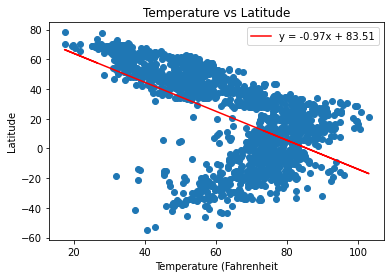

In [37]:
############################
# Temp vs Latitude Scatter #
############################
plt.scatter(data["Temperature (Fahrenheit)"], data["Latitude"])
plt.title("Temperature vs Latitude")
plt.xlabel("Temperature (Fahrenheit")
plt.ylabel("Latitude")

result = st.linregress(
    data["Temperature (Fahrenheit)"],
    data["Latitude"]
)
formula = result.slope * data["Temperature (Fahrenheit)"] + result.intercept
plt.plot(
    data["Temperature (Fahrenheit)"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()

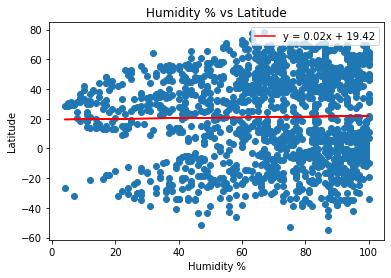

In [38]:
################################
# Humidity vs Latitude Scatter #
################################
plt.scatter(data["Humidity"], data["Latitude"])
plt.title("Humidity % vs Latitude")
plt.xlabel("Humidity %")
plt.ylabel("Latitude")

result = st.linregress(
    data["Humidity"],
    data["Latitude"]
)
formula = result.slope * data["Humidity"] + result.intercept
plt.plot(
    data["Humidity"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()

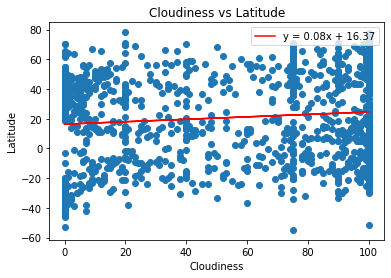

In [39]:
##################################
# Cloudiness vs Latitude Scatter #
##################################
plt.scatter(data["Cloudiness"], data["Latitude"])
plt.title("Cloudiness vs Latitude")
plt.xlabel("Cloudiness")
plt.ylabel("Latitude")

result = st.linregress(
    data["Cloudiness"],
    data["Latitude"]
)
formula = result.slope * data["Cloudiness"] + result.intercept
plt.plot(
    data["Cloudiness"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()

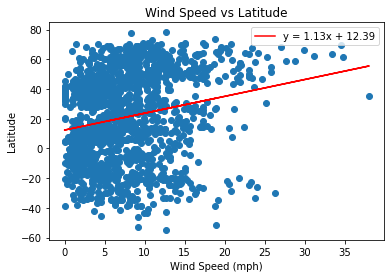

In [44]:
##################################
# Wind Speed vs Latitude Scatter #
##################################
plt.scatter(data["Wind Speed (mph)"], data["Latitude"])
plt.title("Wind Speed vs Latitude")
plt.xlabel("Wind Speed (mph)")
plt.ylabel("Latitude")

result = st.linregress(
    data["Wind Speed (mph)"],
    data["Latitude"]
)
formula = result.slope * data["Wind Speed (mph)"] + result.intercept
plt.plot(
    data["Wind Speed (mph)"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()

#### Northern Hemisphere

In [12]:
##################################################################
# Create a DataFrame that limits to only the Northern Hemisphere #
##################################################################
NH_data = data.loc[data["Latitude"] >= 0]

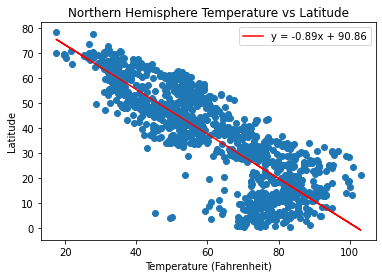

In [47]:
####################
# Temp vs Latitude #
####################
plt.scatter(NH_data["Temperature (Fahrenheit)"], NH_data["Latitude"])
plt.title("Northern Hemisphere Temperature vs Latitude")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Latitude")

result = st.linregress(
    NH_data["Temperature (Fahrenheit)"],
    NH_data["Latitude"]
)
formula = result.slope * NH_data["Temperature (Fahrenheit)"] + result.intercept
plt.plot(
    NH_data["Temperature (Fahrenheit)"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()

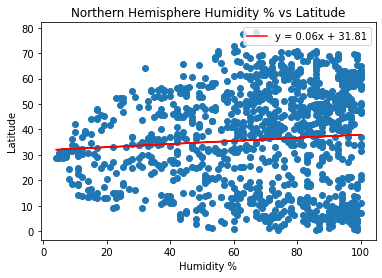

In [48]:
########################
# Humidity vs Latitude #
########################
plt.scatter(NH_data["Humidity"], NH_data["Latitude"])
plt.title("Northern Hemisphere Humidity % vs Latitude")
plt.xlabel("Humidity %")
plt.ylabel("Latitude")

result = st.linregress(
    NH_data["Humidity"],
    NH_data["Latitude"]
)
formula = result.slope * NH_data["Humidity"] + result.intercept
plt.plot(
    NH_data["Humidity"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()

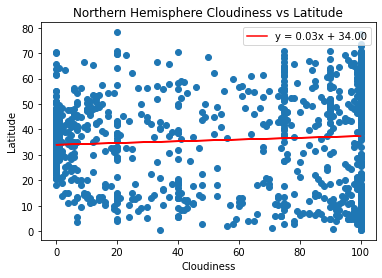

In [49]:
##########################
# Cloudiness vs Latitude #
##########################
plt.scatter(NH_data["Cloudiness"], NH_data["Latitude"])
plt.title("Northern Hemisphere Cloudiness vs Latitude")
plt.xlabel("Cloudiness")
plt.ylabel("Latitude")

result = st.linregress(
    NH_data["Cloudiness"],
    NH_data["Latitude"]
)
formula = result.slope * NH_data["Cloudiness"] + result.intercept
plt.plot(
    NH_data["Cloudiness"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()

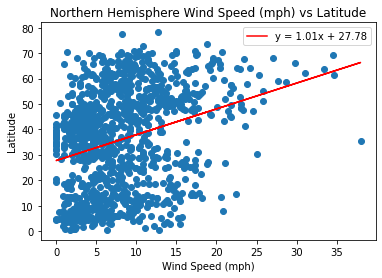

In [50]:
##########################
# Wind Speed vs Latitude #
##########################
plt.scatter(NH_data["Wind Speed (mph)"], NH_data["Latitude"])
plt.title("Northern Hemisphere Wind Speed (mph) vs Latitude")
plt.xlabel("Wind Speed (mph)")
plt.ylabel("Latitude")

result = st.linregress(
    NH_data["Wind Speed (mph)"],
    NH_data["Latitude"]
)
formula = result.slope * NH_data["Wind Speed (mph)"] + result.intercept
plt.plot(
    NH_data["Wind Speed (mph)"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()

#### Southern Hemisphere

In [17]:
##################################################################
# Create a DataFrame that limits to only the Southern Hemisphere #
##################################################################
SH_data = data.loc[data["Latitude"] <= 0]

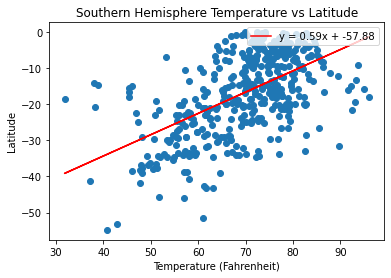

In [51]:
####################
# Temp vs Latitude #
####################
plt.scatter(SH_data["Temperature (Fahrenheit)"], SH_data["Latitude"])
plt.title("Southern Hemisphere Temperature vs Latitude")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Latitude")

result = st.linregress(
    SH_data["Temperature (Fahrenheit)"],
    SH_data["Latitude"]
)
formula = result.slope * SH_data["Temperature (Fahrenheit)"] + result.intercept
plt.plot(
    SH_data["Temperature (Fahrenheit)"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()

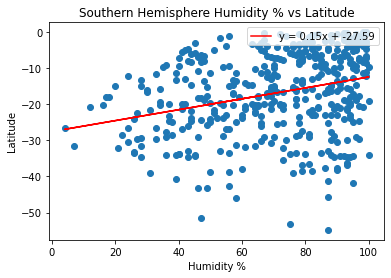

In [52]:
########################
# Humidity vs Latitude #
########################
plt.scatter(SH_data["Humidity"], SH_data["Latitude"])
plt.title("Southern Hemisphere Humidity % vs Latitude")
plt.xlabel("Humidity %")
plt.ylabel("Latitude")

result = st.linregress(
    SH_data["Humidity"],
    SH_data["Latitude"]
)
formula = result.slope * SH_data["Humidity"] + result.intercept
plt.plot(
    SH_data["Humidity"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()

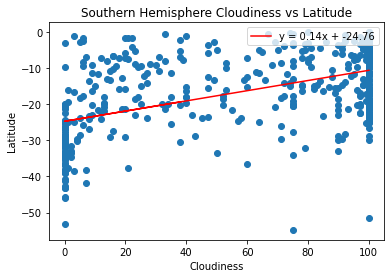

In [53]:
##########################
# Cloudiness vs Latitude #
##########################
plt.scatter(SH_data["Cloudiness"], SH_data["Latitude"])
plt.title("Southern Hemisphere Cloudiness vs Latitude")
plt.xlabel("Cloudiness")
plt.ylabel("Latitude")

result = st.linregress(
    SH_data["Cloudiness"],
    SH_data["Latitude"]
)
formula = result.slope * SH_data["Cloudiness"] + result.intercept
plt.plot(
    SH_data["Cloudiness"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()

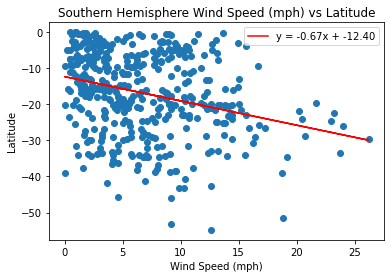

In [54]:
##########################
# Wind Speed vs Latitude #
##########################
plt.scatter(SH_data["Wind Speed (mph)"], SH_data["Latitude"])
plt.title("Southern Hemisphere Wind Speed (mph) vs Latitude")
plt.xlabel("Wind Speed (mph)")
plt.ylabel("Latitude")

result = st.linregress(
    SH_data["Wind Speed (mph)"],
    SH_data["Latitude"]
)
formula = result.slope * SH_data["Wind Speed (mph)"] + result.intercept
plt.plot(
    SH_data["Wind Speed (mph)"],
    formula,
    color='red',
    label=f'y = {"{:.2f}".format(result.slope)}x + {"{:.2f}".format(result.intercept)}'
)

plt.legend(loc="upper right")
plt.show()